In [1]:
import numpy as np
import torch
import random
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()
import dense_correspondence
from importlib import reload
reload(dense_correspondence)
from dense_correspondence.training.training import *
import sys
import logging
import json
import time

#utils.set_default_cuda_visible_devices()
# utils.set_cuda_visible_devices([0]) # use this to manually set CUDA_VISIBLE_DEVICES

import dense_correspondence.dataset.spartan_dataset_masked
reload(dense_correspondence.dataset.spartan_dataset_masked)
import dense_correspondence.training.training
reload(dense_correspondence.training.training)
from dense_correspondence.training.training import DenseCorrespondenceTraining
from dense_correspondence.dataset.spartan_dataset_masked import SpartanDataset, OPDataSelector
logging.basicConfig(level=logging.INFO)

import dense_correspondence.evaluation.evaluation
reload(dense_correspondence.evaluation.evaluation)
from dense_correspondence.evaluation.evaluation import DenseCorrespondenceEvaluation

# Multi Object Pursuit
utils.add_object_pursuit_to_python_path()
import object_pursuit
reload(object_pursuit)
from dense_correspondence.training.op_training import OPMultiDenseCorrespondenceTraining

from dense_correspondence.network.op_dense_correspondence_network import \
    OPMultiDenseCorrespondenceNetwork, OPMultiDenseCorrespondenceNetworkV2

cuda = torch.cuda.is_available()
DEVICE = "cuda:1" if cuda else "cpu"
if cuda:
    print("CUDA GPU!")
else:
    print("CPU!")

CUDA GPU!


In [3]:
!python3 -m pip install tensorboard_logger

/usr/bin/python3: No module named pip


## Load the configuration for training

In [4]:
# Dataset
verbose = False
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence', 
                               'dataset', 'composite', 'op_pretraining.yaml')
data_config = utils.getDictFromYamlFilename(config_filename)
data_config['logs_root_path'] = '/home/ashek/code/data/pdc/logs_proto'

# Training
train_config_file = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence', 
                               'training', 'op_pretraining.yaml')
train_config = utils.getDictFromYamlFilename(train_config_file)
train_config['device'] = DEVICE
train_config['dense_correspondence_network']['device'] = DEVICE

logging_dir = "/home/ashek/code/data/pdc/trained_models/tutorials"
num_iterations = 5000
d = 3 # the descriptor dimension
datetime_str = time.strftime('%Y_%m_%d_%H:%M:%S', time.localtime())
name = "op_multinet_pretraining_" + datetime_str
train_config["training"]["logging_dir_name"] = name
train_config["training"]["logging_dir"] = logging_dir
train_config["dense_correspondence_network"]["descriptor_dimension"] = d
train_config["training"]["num_iterations"] = num_iterations
print(json.dumps(train_config, indent=2))

{
  "training": {
    "learning_rate": 0.0001,
    "learning_rate_decay": 0.9,
    "steps_between_learning_rate_decay": 250,
    "weight_decay": 0.0001,
    "num_iterations": 5000,
    "num_workers": 5,
    "compute_test_loss": true,
    "compute_test_loss_rate": 500,
    "num_test_imgs_per_scene": 1,
    "test_loss_num_iterations": 36,
    "garbage_collect_rate": 1,
    "batch_size": 1,
    "domain_randomize": true,
    "num_matching_attempts": 10000,
    "sample_matches_only_off_mask": true,
    "num_non_matches_per_match": 150,
    "fraction_masked_non_matches": 0.5,
    "fraction_background_non_matches": 0.5,
    "use_image_b_mask_inv": true,
    "cross_scene_num_samples": 10000,
    "data_type_probabilities": {
      "SINGLE_OBJECT_WITHIN_SCENE": 1,
      "SINGLE_OBJECT_ACROSS_SCENE": 0,
      "DIFFERENT_OBJECT": 0,
      "MULTI_OBJECT": 0,
      "SYNTHETIC_MULTI_OBJECT": 0
    },
    "loss_function": "pixelwise_contrastive_loss",
    "logging_rate": 100,
    "save_rate": 1000,
  

## Train the network

This should take about ~12-15 minutes with a GTX 1080 Ti

In [5]:
# dataset.get_pose_data(dataset.get_scene_list()[0])
data_config

{'logs_root_path': '/home/ashek/code/data/pdc/logs_proto',
 'single_object_scenes_config_files': ['10_drill_scenes.yaml',
  'caterpillar_upright.yaml',
  'dramamine.yaml',
  'gopro_box.yaml',
  'headphones.yaml'],
 'multi_object_scenes_config_files': []}

dict_keys(['training', 'dense_correspondence_network', 'loss_function', 'device'])
training descriptor of dimension 3


INFO:root:Loading pose data for scene 05_drill_long_downsampled
INFO:root:Loading pose data for scene 07_drill_long_downsampled
INFO:root:Loading pose data for scene 08_drill_long_downsampled


Using SpartanDataset:
   - in train mode
   - number of scenes 40
   - total images:     12869
DATASET MODE: train
Using SpartanDataset:
   - in test mode
   - number of scenes 11
   - total images:     3904
DATASET MODE: test


INFO:root:Loading pose data for scene 09_drill_long_downsampled
INFO:root:Loading pose data for scene 10_drill_long_downsampled
INFO:root:Loading pose data for scene 12_drill_long_downsampled
INFO:root:Loading pose data for scene 13_drill_long_downsampled
INFO:root:Loading pose data for scene 2018-04-10-16-02-59
INFO:root:Loading pose data for scene 2018-04-10-16-04-10
INFO:root:Loading pose data for scene 2018-04-10-16-06-26
INFO:root:Loading pose data for scene 2018-04-10-16-12-21
INFO:root:Loading pose data for scene 2018-04-10-16-13-37
INFO:root:Loading pose data for scene 2018-04-10-16-16-15
INFO:root:Loading pose data for scene 2018-04-16-14-25-19
INFO:root:Loading pose data for scene 2018-04-16-14-40-25
INFO:root:Loading pose data for scene 2018-04-10-16-08-46
INFO:root:Loading pose data for scene 2018-04-16-14-44-53
INFO:root:Loading pose data for scene 2018-04-16-15-23-41
INFO:root:Loading pose data for scene 2018-04-24-17-46-59
INFO:root:Loading pose data for scene 2018-04-24

using SINGLE_OBJECT_WITHIN_SCENE


INFO:root:Loading pose data for scene 2018-04-16-14-46-36
INFO:root:Loading pose data for scene 2018-04-24-18-05-58
INFO:root:Loading pose data for scene 2018-04-24-18-07-45
INFO:root:Loading pose data for scene 2018-04-24-16-55-07
INFO:root:Loading pose data for scene 2018-04-24-16-56-52
INFO:root:Loading pose data for scene 2018-04-24-16-39-23
INFO:root:Loading pose data for scene 2018-04-24-16-37-27
INFO:root:enabling domain randomization
INFO:root:setting up tensorboard_logger
INFO:root:tensorboard logger started


using SINGLE_OBJECT_WITHIN_SCENE
using SINGLE_OBJECT_WITHIN_SCENE
using SINGLE_OBJECT_WITHIN_SCENE
dir_name:  op_multinet_pretraining_2022_06_07_21:16:05
logging_dir: /home/ashek/code/data/pdc/trained_models/tutorials/op_multinet_pretraining_2022_06_07_21:16:05
ResNeet34 OP freeze backbone: False


  0%|          | 1/5000 [00:00<16:13,  5.13it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3669: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
  0%|          | 2/5000 [00:03<2:46:10,  1.99s/it]

No losses, skipping...


INFO:root:Computing test loss




-----------Test Data Evaluation on caterpillar----------------
Image pair (1890, 305)
Could not find descriptor image stats...
Only normalizing pairs of images!


/home/ashek/code/dense_correspondence/network/op_dense_correspondence_network.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img_tensor, device=self.device)


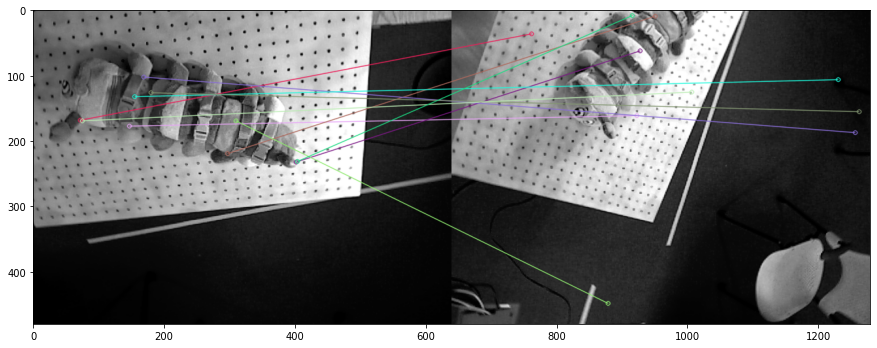

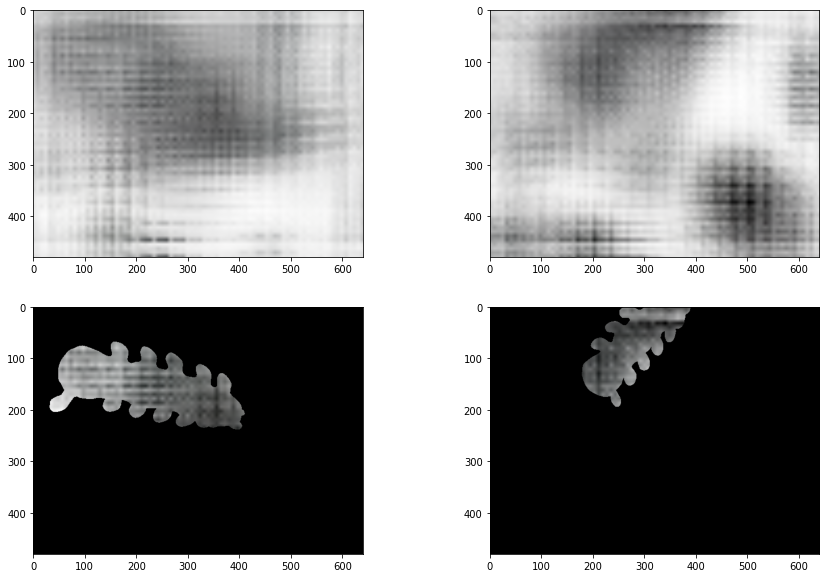



-----------Test Data Evaluation on dramamine----------------
Image pair (0, 334)
Could not find descriptor image stats...
Only normalizing pairs of images!


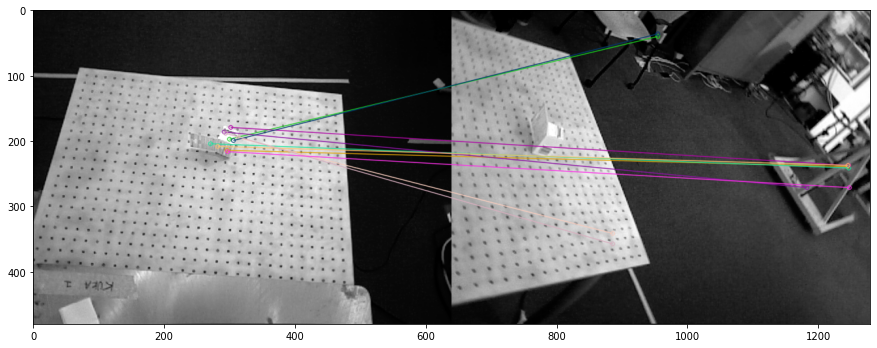

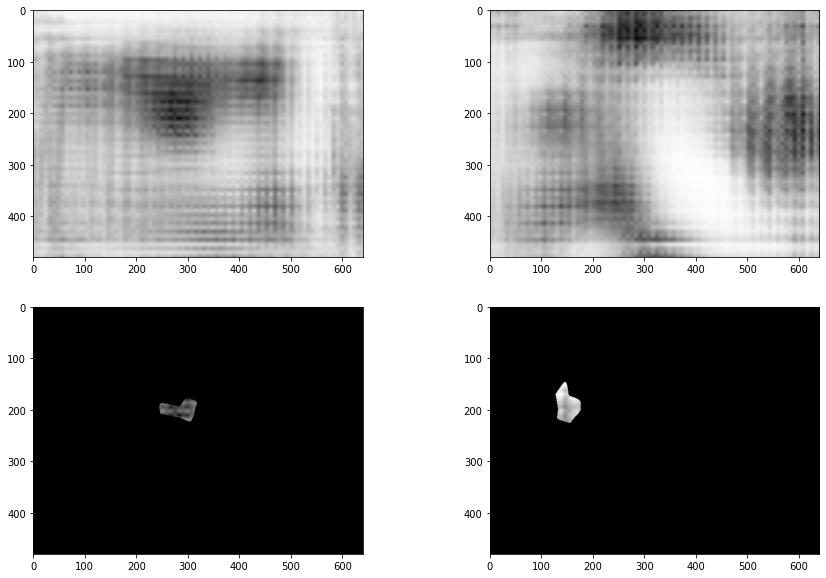



-----------Test Data Evaluation on drill----------------
Image pair (533, 105)
Could not find descriptor image stats...
Only normalizing pairs of images!


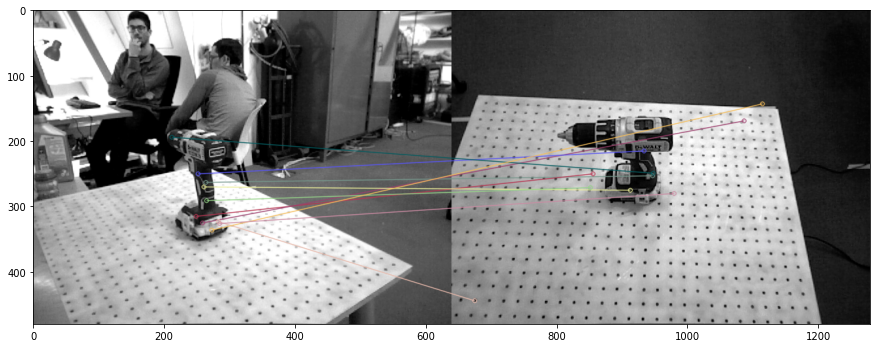

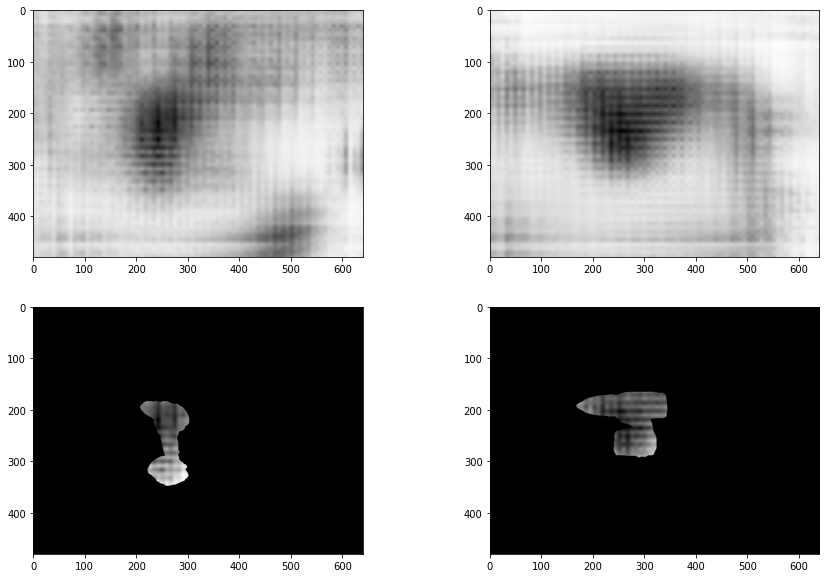



-----------Test Data Evaluation on gopro_box----------------
Image pair (1356, 2192)
Could not find descriptor image stats...
Only normalizing pairs of images!


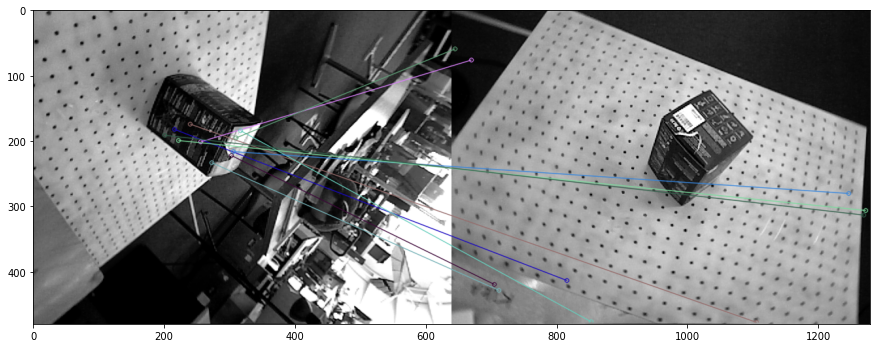

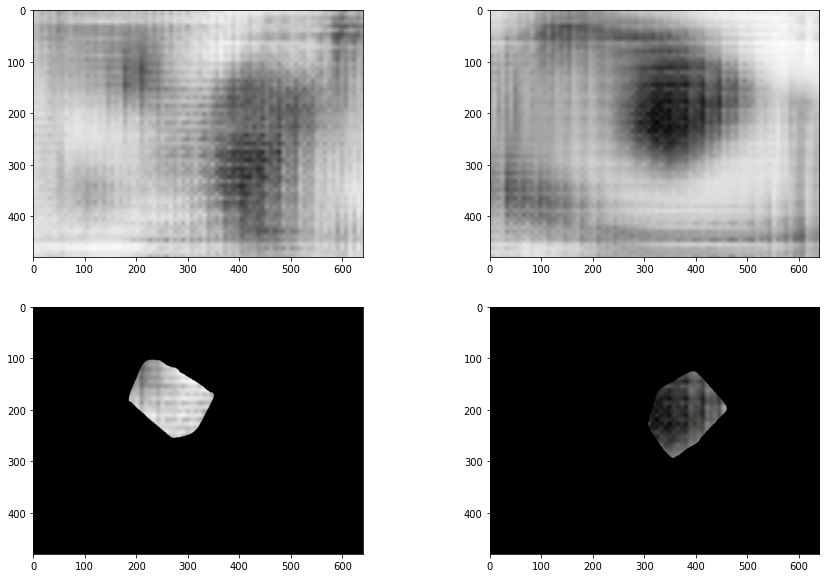



-----------Test Data Evaluation on headphones----------------
Image pair (1905, 2422)
Could not find descriptor image stats...
Only normalizing pairs of images!


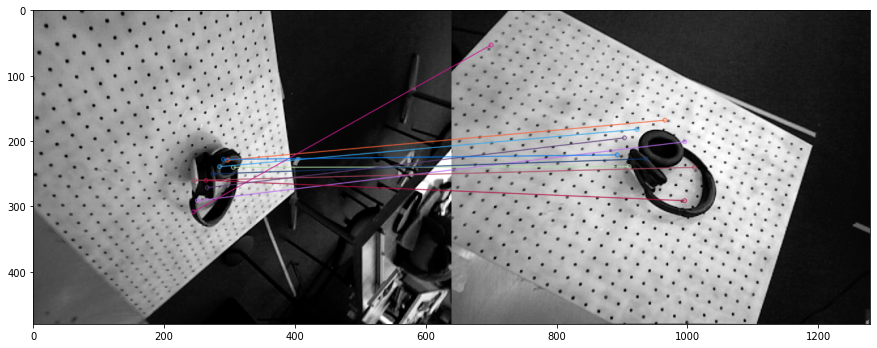

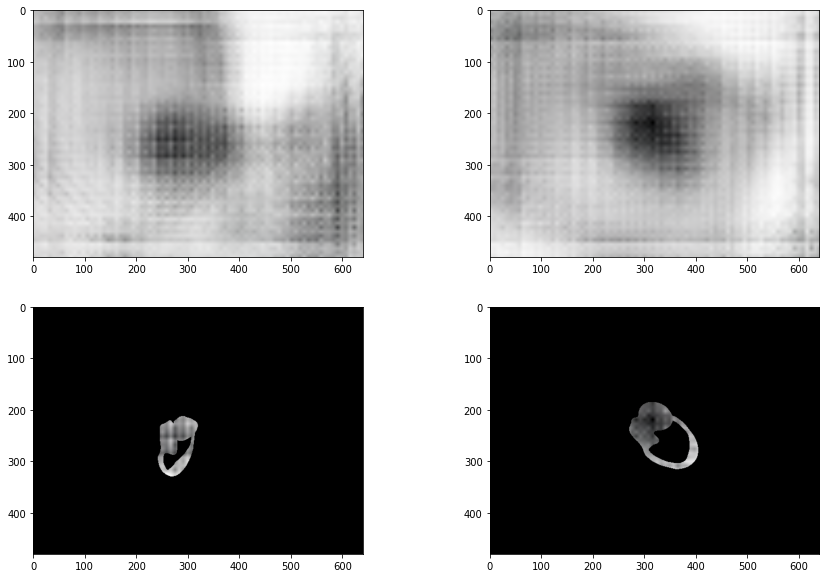

INFO:root:Test loss @ iter 0\%:
test_losss: 51.896610260009766, test_match_loss: 51.83449935913086, test_non_match_loss: 0.060385122895240784
  0%|          | 3/5000 [00:12<7:21:05,  5.30s/it]INFO:root:Computing test loss




-----------Test Data Evaluation on caterpillar----------------
Image pair (699, 440)
Could not find descriptor image stats...
Only normalizing pairs of images!


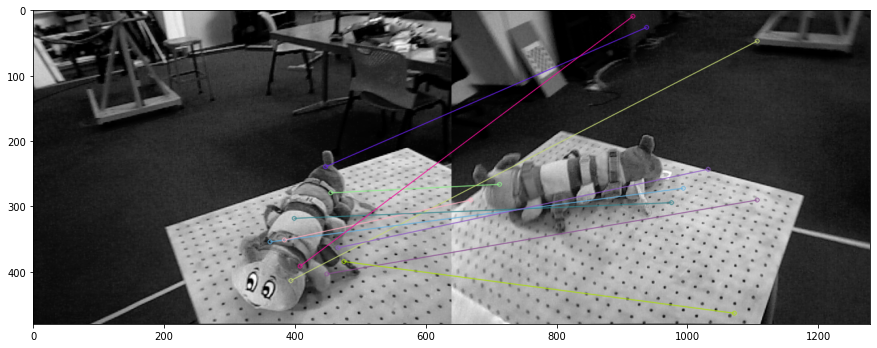

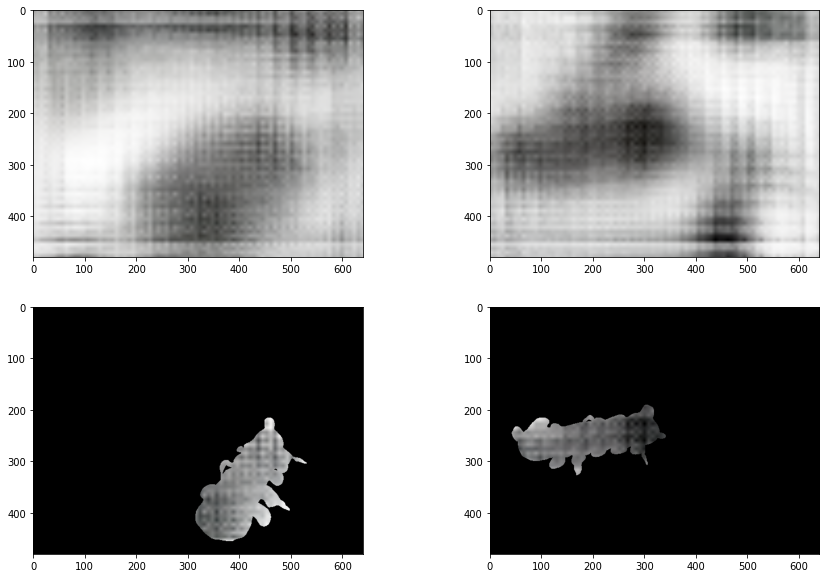



-----------Test Data Evaluation on dramamine----------------
Image pair (2244, 1908)
Could not find descriptor image stats...
Only normalizing pairs of images!


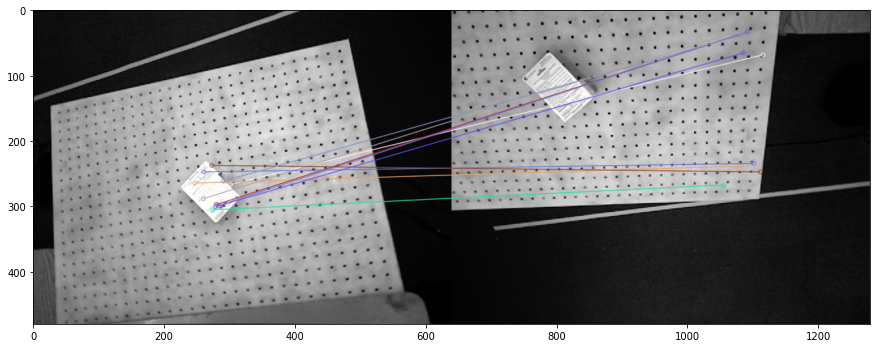

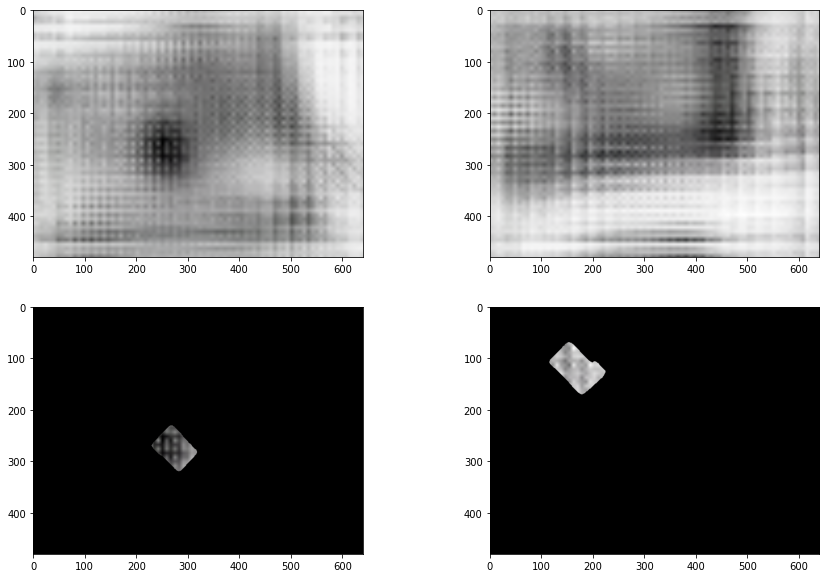



-----------Test Data Evaluation on drill----------------
Image pair (1221, 1010)
Could not find descriptor image stats...
Only normalizing pairs of images!


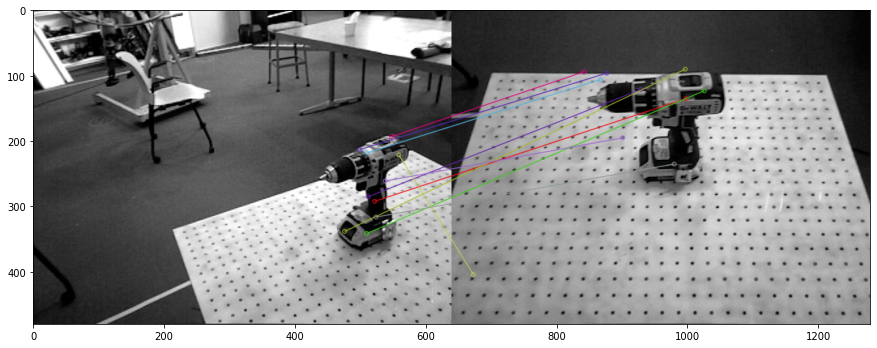

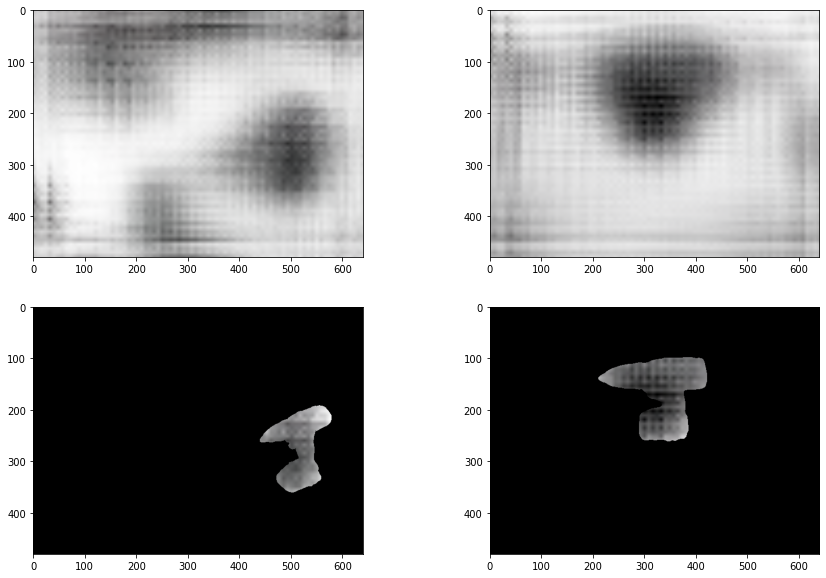



-----------Test Data Evaluation on gopro_box----------------
Image pair (1838, 246)
Could not find descriptor image stats...
Only normalizing pairs of images!


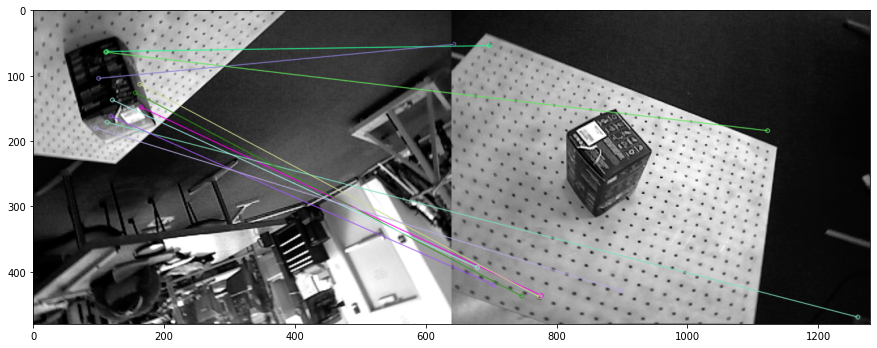

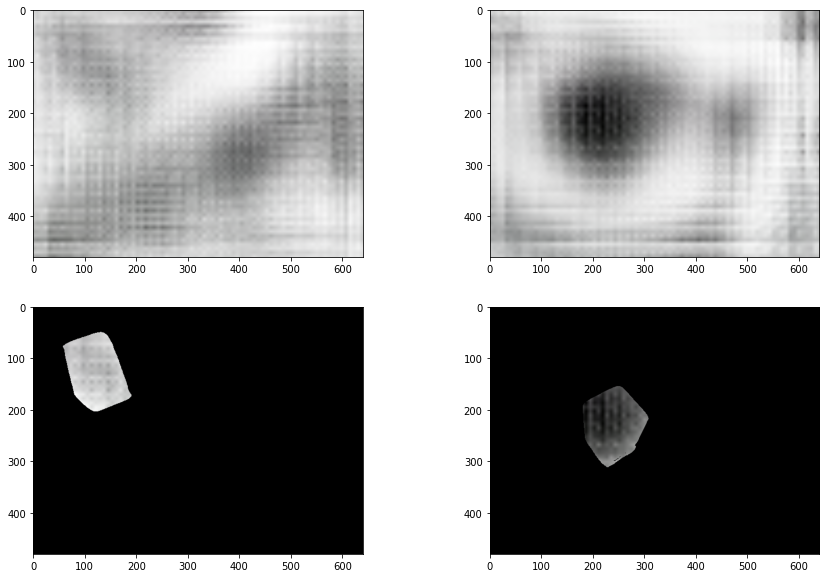



-----------Test Data Evaluation on headphones----------------
Image pair (1278, 2401)
Could not find descriptor image stats...
Only normalizing pairs of images!


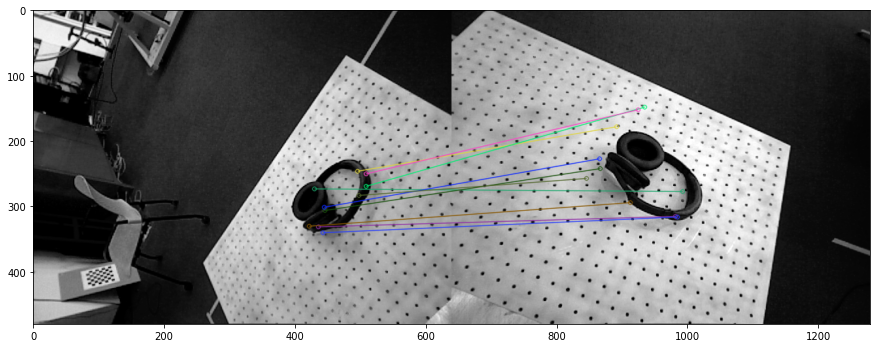

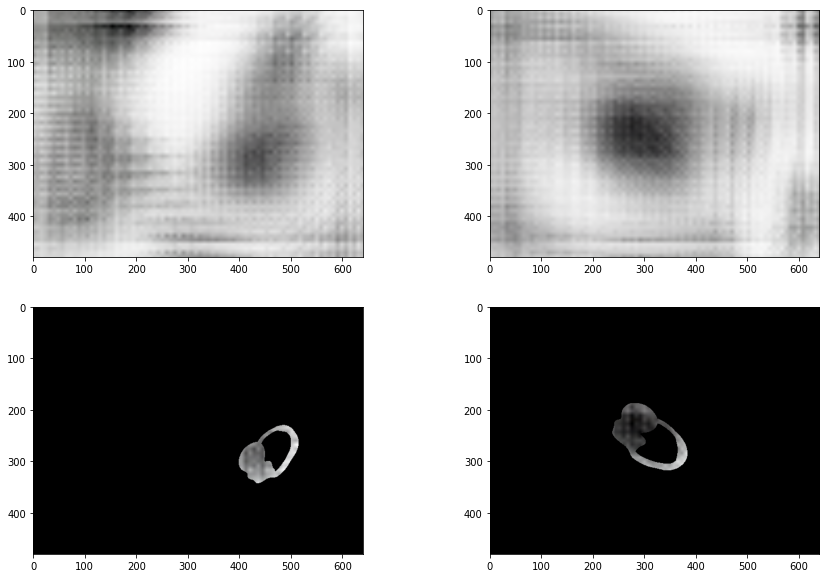

INFO:root:Test loss @ iter 0\%:
test_losss: 62.965660095214844, test_match_loss: 62.898921966552734, test_non_match_loss: 0.060062225908041
  0%|          | 4/5000 [00:21<9:24:37,  6.78s/it]INFO:root:Computing test loss


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ashek/code/dense_correspondence/dataset/spartan_dataset_masked.py", line 131, in __getitem__
    return self.get_single_object_within_scene_data()
  File "/home/ashek/code/dense_correspondence/dataset/spartan_dataset_masked.py", line 598, in get_single_object_within_scene_data
    return self.get_within_scene_data(scene_name, metadata)
  File "/home/ashek/code/dense_correspondence/dataset/spartan_dataset_masked.py", line 698, in get_within_scene_data
    image_a_depth_numpy, image_a_pose, image_b_depth_numpy, image_b_pose, img_a_mask=correspondence_mask, num_attempts=self.num_matching_attempts)
  File "/home/ashek/code/dense_correspondence/correspondence_tools/correspondence_finder.py", line 525, in batch_find_pixel_correspondences
    img_a_depth_torch, 0, uv_a_vec_flattened) * 1.0 / DEPTH_IM_SCALE
IndexError: index out of range in self


In [6]:
# All of the saved data for this network will be located in the
# code/data/pdc/trained_models/tutorials/caterpillar_3 folder
print(train_config.keys())
print("training descriptor of dimension %d" %(d))
NetworkClass = OPMultiDenseCorrespondenceNetworkV2
# NetworkClass = OPMultiDenseCorrespondenceNetwork
train_config["dense_correspondence_network"]["model_class"] = str(NetworkClass)
train = OPMultiDenseCorrespondenceTraining(NetworkClass=NetworkClass, config=train_config)
train.load_dataset_from_config(config=data_config)
train.run()
print("finished training descriptor of dimension %d" %(d))

# Each batch, select a random image from a random scene
# for that image, find another image from the same scene
# but a taken from a diff view.
# then generate both pixel matches and non-matches 
# yes there is a heuristic approach, but it seeems complex
# and thus runtime is long. Prune non-matches based on:
# 1. depth is 0 (thus invalid, cannot use)
# 2. Project pixels from im1 to onto im2 and check if outside FOV
# 3. check if pixel is occluded using some method
# complicated... don't touch

# Fine-tune on New Objects

In [ ]:
# New objects
# Datasets available:
# caterpillar_upright
# mugs
# shoes
# drills
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence', 
                               'dataset', 'composite', 'finetune.yaml')
finetune_config = utils.getDictFromYamlFilename(config_filename)
finetune_config['logs_root_path'] = '/home/ashek/code/data/pdc/logs_proto'
finetune_dataset = SpartanDataset(config=finetune_config)
print(json.dumps(finetune_config, indent=2))

In [ ]:
num_iterations = 1500
d = 3 # the descriptor dimension
train_config["training"]["num_iterations"] = num_iterations
print(json.dumps(train_config, indent=2))

In [ ]:
model_folder = os.path.join(logging_dir, name)
model_folder = utils.convert_data_relative_path_to_absolute_path(model_folder)
print("Loading %s" % model_folder)
iteration = 3501
print "training descriptor of dimension %d" %(d)
finetune = DenseCorrespondenceTraining(dataset=finetune_dataset, config=train_config)
finetune.run_from_pretrained(model_folder, iteration)
print "finished training descriptor of dimension %d" %(d)

In [ ]:
!ls /home/ashek/code/data/pdc/trained_models/tutorials/caterpillar_3

## Evaluate the network quantitatively

This should take ~5 minutes.

In [ ]:
# Evaluate initial model (no fine-tuning) on original train dataset
DCE = DenseCorrespondenceEvaluation
iteration = 3501
num_image_pairs = 100
save_folder_name = "analysis"
DCE.run_evaluation_on_network(model_folder, iteration=iteration, num_image_pairs=num_image_pairs,
                             dataset=dataset, save_folder_name=save_folder_name)      

In [ ]:
# Evaluate fine-tuned model on original train dataset
iteration = 5002
num_image_pairs = 100
save_folder_name = "finetune_analysis_orig_data"
DCE.run_evaluation_on_network(model_folder, iteration=iteration, num_image_pairs=num_image_pairs,
                             dataset=dataset, save_folder_name=save_folder_name)         

In [ ]:
# Evaluate fine-tuned model on new finetuned dataset
DCE = DenseCorrespondenceEvaluation
iteration = 5002
num_image_pairs = 100
save_folder_name = "finetune_analysis_finetune_data"
DCE.run_evaluation_on_network(model_folder, iteration=iteration, num_image_pairs=num_image_pairs,
                             dataset=finetune_dataset, save_folder_name=save_folder_name)      

See `evaluation_quantitative_tutorial.ipynb` for a better place to display the plots.

In [ ]:

        return matches_a, matches_b, masked_non_matches_a, masked_non_matches_b, blind_non_matches_a, blind_non_matches_b# Finetune on 2nd additional dataset just to emphasize issue further
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence', 
                               'dataset', 'composite', 'finetune2.yaml')
finetune2_config = utils.getDictFromYamlFilename(config_filename)
finetune2_config['logs_root_path'] = '/home/ashek/code/data/pdc/logs_proto'
finetune2_dataset = SpartanDataset(config=finetune_config)
print(json.dumps(finetune2_config, indent=2))

In [ ]:
model_folder = os.path.join(logging_dir, name)
model_folder = utils.convert_data_relative_path_to_absolute_path(model_folder)
print("Loading %s" % model_folder)
iteration = 5002
print "training descriptor of dimension %d" %(d)
finetune2 = DenseCorrespondenceTraining(dataset=finetune2_dataset, config=train_config)
finetune2.run_from_pretrained(model_folder, iteration)
print "finished training descriptor of dimension %d" %(d)

In [ ]:
# Evaluate fine-tuned2 model on new finetuned2 dataset
DCE = DenseCorrespondenceEvaluation
iteration = 6503
num_image_pairs = 100
save_folder_name = "finetune2_analysis_finetune_data2"
DCE.run_evaluation_on_network(model_folder, iteration=iteration, num_image_pairs=num_image_pairs,
                             dataset=finetune2_dataset, save_folder_name=save_folder_name)      

In [ ]:
# Evaluate fine-tuned model on original train dataset
iteration = 6503
num_image_pairs = 100
save_folder_name = "finetune2_analysis_orig_data"
DCE.run_evaluation_on_network(model_folder, iteration=iteration, num_image_pairs=num_image_pairs,
                             dataset=dataset, save_folder_name=save_folder_name)         